In [1]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pandas as pd

from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

from sklearn.metrics import balanced_accuracy_score, confusion_matrix

import sklearn
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math

# custom function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
# some_file.py
import sys
#change location to GNN_RIVM folder
sys.path.insert(1, '/home/jeroen/Documents/Toxic/GNN_rivm/benchmark')

from nets.TUs_graph_classification.load_net import gnn_model # import GNNs
from data.data import LoadData # import dataset
from train.train_TUs_graph_classification import train_epoch, evaluate_network, evaluate_network2 # import train functions

drop_last = False
device = torch.device("cpu")

In [3]:
def create_net_params(file_name):
    f = open(file_name, "r")
    n_params = (f.readlines()[5].split(" "))
    net_params = dict()
    pbt_params_int = ['in_dim', 'hidden_dim', 'out_dim', 'n_classes', 'L']
    int_idx = [27,3,5,29,1]
    pbt_params_str = ['readout', 'graph_norm', 'batch_norm', 'residual']
    str_idx = [9,15,17,7]
    
    for idx1, par in enumerate(pbt_params_int):
        net_params[par] = int(n_params[int_idx[idx1]].split(',')[0])
    net_params['dropout'] = float(n_params[13].split(',')[0])
    for idx2, par in enumerate(pbt_params_str):
        net_params[par] =  n_params[str_idx[idx2]].split(',')[0].strip("'")
    return net_params 

In [4]:
folder = "GatedPBT/"
model_str = "GatedGCN"

gin1_file = "GatedGCN_PBT_Rep1_GPU0_22h12m21s_on_Jul_03_2020"
gin2_file = "GatedGCN_PBT_Rep2_GPU0_08h19m59s_on_Jul_01_2020"
gin3_file = "GatedGCN_PBT_Rep3_GPU0_08h19m59s_on_Jul_01_2020"
gin4_file = "GatedGCN_PBT_Rep4_GPU0_22h12m14s_on_Jul_03_2020"

In [5]:
gin1_np = create_net_params(folder+"config_"+gin1_file+".txt")
gin2_np = create_net_params(folder+"config_"+gin2_file+".txt")
gin3_np = create_net_params(folder+"config_"+gin3_file+".txt")
gin4_np = create_net_params(folder+"config_"+gin4_file+".txt")

In [6]:
print(gin1_np)
print(gin2_np)
print(gin3_np)
print(gin4_np)

{'in_dim': 15, 'hidden_dim': 96, 'out_dim': 96, 'n_classes': 2, 'L': 6, 'dropout': 0.5, 'readout': 'mean', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 23, 'hidden_dim': 128, 'out_dim': 64, 'n_classes': 2, 'L': 4, 'dropout': 0.5, 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 19, 'hidden_dim': 128, 'out_dim': 64, 'n_classes': 2, 'L': 4, 'dropout': 0.5, 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 86, 'hidden_dim': 96, 'out_dim': 96, 'n_classes': 2, 'L': 6, 'dropout': 0.5, 'readout': 'mean', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}


In [6]:
dataset1 = LoadData("PBT_Rep1")
dataset2 = LoadData("PBT_Rep2")
dataset3 = LoadData("PBT_Rep3")
dataset4 = LoadData("PBT_Rep4")

494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep1
Time taken: 5.5384s
494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep2
Time taken: 12.1303s
494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep3
Time taken: 11.2790s
494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep4
Time taken: 6.3854s


In [7]:
drop_last = True
device = torch.device("cpu")

In [8]:
def test_model(net_params, model_name, dataset, model_str):
    accs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
#         train_loader = DataLoader(trainset, batch_size=20, shuffle=True, drop_last=drop_last, collate_fn=dataset.collate)
#         val_loader = DataLoader(valset, batch_size=20, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, epoch_val_acc = evaluate_network(model, device, test_loader, 999)
        accs.append(epoch_val_acc)
    print(np.mean(accs),np.std(accs))
#     print(accs)

In [9]:
def test_model2(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.extend(score)
        labs.extend(labels)
    return accs, labs

In [10]:
def test_model3(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.append(score)
        labs.append(labels)
    return accs, labs

In [11]:
test_model(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
test_model(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
test_model(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
test_model(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

0.9220709115445956 0.047093152368508286
0.9242301558091033 0.04846217795651062
0.9020411605937921 0.0488887312505047
0.9148018648018649 0.03765451760316066


In [12]:
accs1, labels1 = test_model2(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
accs2, labels2 = test_model2(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
accs3, labels3 = test_model2(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
accs4, labels4 = test_model2(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

In [13]:
acclist1, lablist1 = test_model3(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
acclist2, lablist2 = test_model3(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
acclist3, lablist3 = test_model3(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
acclist4, lablist4 = test_model3(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

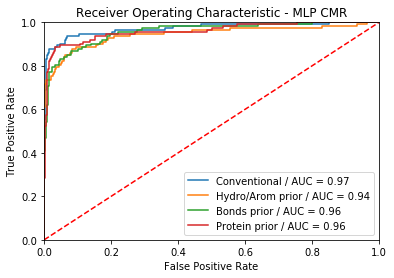

In [14]:
accuracies = [accs1, accs2, accs3, accs4]
acclists = [acclist1, acclist2, acclist3, acclist4]

labels = ["Conventional", "Hydro/Arom prior", "Bonds prior", "Protein prior"]
for idx, ac in enumerate(accuracies):
    fpr, tpr, threshold = metrics.roc_curve(labels1, sigmoid(np.array(ac))[:,1])
    roc_auc = metrics.roc_auc_score(labels1, sigmoid(np.array(ac))[:,1])
    plt.title('Receiver Operating Characteristic - MLP CMR')
    plt.plot(fpr, tpr, label = labels[idx]+' / AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
for acc in acclists:
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc):
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
#     print(rec)
    print("%.4f %.4f" % (np.mean(pre), np.mean(rec)))
#     print("%.4f" % np.mean(pre), np.std(pre))

0.8523 0.8939
0.9049 0.8773
0.7940 0.8750
0.8242 0.8924


In [16]:
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(pre), np.mean(rec)])
        
df = pd.DataFrame(accs)
for a in list(df.values):
    print("%.2f %.2f" % (a[1],a[2]))
rep123r=[]
rep124r=[]
rep1234r=[]
rep123p=[]
rep124p=[]
rep1234p=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep123p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep124r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep124p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep1234p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print("%.2f %.2f" % (np.mean(rep123p), np.mean(rep123r)))
print("%.2f %.2f" % (np.mean(rep124p), np.mean(rep124r)))
print("%.2f %.2f" % (np.mean(rep1234p), np.mean(rep1234r)))

0.85 0.89
0.92 0.91
0.90 0.91
0.86 0.91
0.92 0.90
0.92 0.90
0.92 0.91


In [18]:
from collections import Counter
idx_wrong = []
idx_wrong2 = []
for acc in accuracies:
    idx_wrong.append(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    idx_wrong2.extend(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    
idx_allwrong  = sorted(list(set(idx_wrong[0])&set(idx_wrong[1])&set(idx_wrong[2])&set(idx_wrong[3])))
print(Counter(Counter(idx_wrong2).values()))
print(len(Counter(idx_wrong2)))
print(idx_allwrong)

Counter({1: 35, 2: 19, 4: 9, 3: 8})
71
[117, 151, 157, 199, 207, 303, 392, 401, 402]


In [19]:
check_list = idx_allwrong
print(np.array(labels1)[check_list])
print(sigmoid(np.array(accs1))[check_list])
print(sigmoid(np.array(accs2))[check_list])
print(sigmoid(np.array(accs3))[check_list])
print(sigmoid(np.array(accs4))[check_list])

[0 1 1 0 1 1 0 1 1]
[[0.28395604 0.64543741]
 [0.9616196  0.08783672]
 [0.81812298 0.22741081]
 [0.35923882 0.563262  ]
 [0.5683787  0.43309909]
 [0.55076463 0.4332652 ]
 [0.09957536 0.82619634]
 [0.74445433 0.3290197 ]
 [0.82365471 0.2768926 ]]
[[0.05887475 0.45753597]
 [0.89786233 0.00896781]
 [0.61990268 0.01792045]
 [0.16595257 0.21975736]
 [0.7811761  0.28375849]
 [0.68556176 0.38742437]
 [0.12096847 0.7070852 ]
 [0.48749217 0.1587958 ]
 [0.46584267 0.04235008]]
[[0.3693922  0.89621625]
 [0.96502612 0.47592867]
 [0.80233775 0.23892381]
 [0.20906214 0.64451971]
 [0.77119795 0.42810407]
 [0.86413317 0.53484231]
 [0.49847189 0.53848751]
 [0.84038675 0.58049671]
 [0.89100145 0.29521846]]
[[0.02904806 0.90835986]
 [0.89366036 0.03081526]
 [0.7976324  0.09701459]
 [0.27687821 0.61198477]
 [0.64278378 0.21355831]
 [0.58476393 0.2717995 ]
 [0.05765936 0.81281001]
 [0.69793258 0.17155697]
 [0.77861557 0.08648309]]


In [14]:
accuracies = [accs1, accs2, accs3, accs4]
for acc in accuracies:
    print(confusion_matrix(labels1, np.argmax(acc, axis=1)))

[[362  19]
 [ 12 101]]
[[370  11]
 [ 14  99]]
[[354  27]
 [ 14  99]]
[[357  24]
 [ 12 101]]


In [20]:
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        acc_temp.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(acc_temp), np.std(acc_temp)])
        
df = pd.DataFrame(accs)
print(df)

   0         1         2
0  0  0.922071  0.047093
1  1  0.943840  0.042615
2  2  0.939926  0.042425
3  3  0.932099  0.038935


In [22]:
rep123=[]
rep124=[]
rep1234=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist4[idx])))/3
    rep124.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print(np.mean(rep123), np.std(rep123))
print(np.mean(rep124), np.std(rep124))
print(np.mean(rep1234), np.std(rep1234))

0.9380122070911543 0.0419974510664607
0.9341323150533676 0.039760885892347574
0.942557661636609 0.04365305289500821


In [23]:
accs = []
for idx1, acc1 in enumerate(accuracies):
    pred = []
    acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(acc1)))/2
    print(idx1+1)
    print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

1
[[362  19]
 [ 12 101]]
2
[[372   9]
 [ 10 103]]
3
[[369  12]
 [ 10 103]]
4
[[363  18]
 [ 10 103]]


In [24]:
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

[[371  10]
 [ 11 102]]
[[368  13]
 [ 11 102]]
[[371  10]
 [ 10 103]]
